## Spread the insertion day of a Delta table over 12 months.

### Task
We have a delta table where all records were inserted on the same day. We need to spread the data ingestion dates over 12 months to simulate a real reporting situation.

### The Boring Stuff...
How do you update the insertion date? Doing it manually seems like a tedious task. If the table had different fields, you could use some of them to filter, but in our case, the table only has the insertion date and ID.
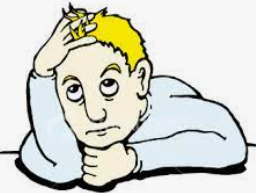

### Solution

The solution must come, as we promote here, from the programming side.

1. Take all the IDs of the data that we need to anonymize.  
2. Divide them into 12 (as it is probably not a multiple of 12, we will need to use floor division to get only the whole number). The number we get will be the size of each chunk.  
3. Divide the list of IDs resulting from point 1 into 12 chunks, with the chunk size determined by point 2.  
4. Get a list of 12 months.  
5. Create a tuple of those 12 months with the 12 chunks from step 3.  
   `[([id1, id2, id3...], '2022-01-01'), ...]`  
6. Finally, iterate through the tuple, dynamically inserting the IDs and the corresponding months.  

In [ ]:
import random
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import random
import math
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Steps 1, 2, 3
sdf = spark.read.format("delta").option("header", True).load(my_path_delta_table)
list_id = sdf.select("conversation_id").distinct().rdd.flatMap(lambda x: x).collect()
random.shuffle(list_id)

len_chunk = len(list_id) // 12
final_list = [list_id[i * len_chunk:(i + 1) * len_chunk] for i in range(11)]
final_list.append(list_id[11 * len_chunk:])

# Step 4
start_date = datetime.today() - relativedelta(months=11)
list_of_months = [(start_date + relativedelta(months=i)).strftime('%Y-%m-%d') for i in range(12)]

# Step 5 and 6
id_per_month = list(zip(final_list, list_of_months))

for ids, month in id_per_month:
    ids_to_insert = ', '.join(f'"{id_}"' for id_ in ids)
    query = f"UPDATE my_table SET day_of_insertion = '{month}' WHERE conversation_id in ({ids_to_insert})"
    spark.sql(query)

# Final Validation
spark.sql("SELECT count(distinct(day_of_insertion)) AS month_conversations FROM my_table").show()


ModuleNotFoundError: No module named 'pyspark'

In [0]:
# Step 4
date_after_month = datetime.today() - relativedelta(months=11)
list_of_monts = []
for year_month in range(12):
    month = (datetime.today() - relativedelta(months=year_month)).strftime('%Y-%m-%d')
    list_of_monts.append(month)

In [0]:
# Step 5 and 6
id_per_month = list(zip(final_list, list_of_monts))

for id, month_tuple in id_per_month:
    ids_to_insert = ''
    ids_to_insert = '"' + '", "'.join(id) + '"'
    month = month_tuple
    query = f"UPDATE my_table SET day_of_insertion = '{month}' WHERE conversation_id in ({ids_to_insert})"
    spark.sql(query)

In [0]:
%sql
select count(distinct(day_of_insertion)) as month_conversatons from my_table 

month_conversatons
12


### End.